In [1]:
%matplotlib inline
%autosave 0

import math
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV

Autosave disabled


# Import dataset 3

In [2]:
data = loadmat("/Users/nunopires/Documents/Coursera/machine-learning-ex6/ex6/ex6data3.mat",
       matlab_compatible = True)

print(data.keys())

X_train = data['X']
y_train = data['y'][:,0]
X_val = data['Xval']
y_val = data['yval'][:,0]

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y', 'yval', 'Xval'])


(106, 105, 87, 113)

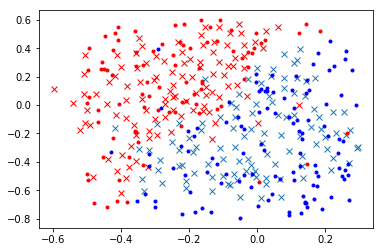

In [3]:
pos_train = X_train[y_train == 1 ,]
neg_train = X_train[y_train == 0 ,]
pos_val = X_val[y_val == 1 ,]
neg_val = X_val[y_val == 0 ,]

plt.plot(neg_train[:,0], neg_train[:,1], 'x');
plt.plot(pos_train[:,0], pos_train[:,1], 'x', color = 'red');
plt.plot(neg_val[:,0], neg_val[:,1], '.', color = 'blue');
plt.plot(pos_val[:,0], pos_val[:,1], '.', color = 'red');

len(pos_train), len(neg_train), len(pos_val), len(neg_val),


In [4]:
def plotBoundary(X, y, svm, mesh = 200):
    '''Plots the SVM boundary.'''
    
    x1 = np.linspace(min(X[:, 0]), max(X[:, 0]), mesh)
    x2 = np.linspace(min(X[:, 1]), max(X[:, 1]), mesh) 
    
    h = []
    for i in x1:
        for j in x2:
            h.append(np.array([i,j]))
            
    z = svm.predict(h).reshape(len(x1), len(x2), order = 'F')
    ''' !! Careful with order or reshape. Preset option 'C' did not work !!'''
    
    # Plot
    on = y == 1 # positives
    off = y == 0 # negatives

    bound = plt.contour(x1, x2, z,
                    levels = [0.5], color = 'red')
    # plt.pcolormesh(x1, x2, z) # alternative
    plt.plot(X[on, 0], X[on, 1], 'x', color = 'blue'); # Y positives
    plt.plot(X[off, 0], X[off, 1], '+', color = 'green'); # Y negatives

### Manually determine best C and gamma parameters

Test range of values for C and sigma as in coursera tutorial. To convert from sigma to gamma, compare kernel formulas between tutorial and [SKlearn guide](http://scikit-learn.org/stable/modules/svm.html#svm-classification)

In [5]:
vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

out = []
for C in vals:
    for sigma in vals:
                
        gamma = 1 / (2 * sigma**2)
        
        clf = svm.SVC(C = C, gamma = gamma)
        clf.fit(X_train, y_train)
        out.append([C, sigma, gamma, clf.score(X_val, y_val)])
        
out = np.array(out)
(a, b, c, d) = out[out[:,3].argmax(),:]

print('Best parameters are C = %1.2f, sigma = %1.2f (-> gamma = %1.1f); score = %1.4f' % (a, b, c, d))

Best parameters are C = 1.00, sigma = 0.10 (-> gamma = 50.0); score = 0.9650


Best parameters from Octave exercise were C = 1, sigma = 0.1

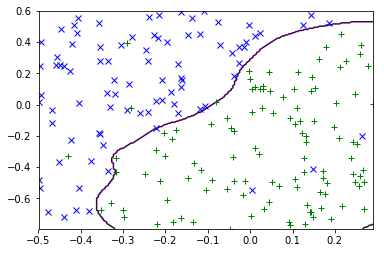

In [6]:
# SVM Parameters
C = 1; gamma = 50;

clf = svm.SVC(C = C, kernel='rbf', gamma = gamma).fit(X_train, y_train)

plotBoundary(X_val, y_val, clf, mesh = 200) # plots only validation values

## Find best parameters using sklearn gridsearch

In [7]:
def make_gamma(x):
    return 1 / (2 * x**2)

Check [SKlearn guide](http://scikit-learn.org/stable/modules/grid_search.html#grid-search-tips)

In [8]:

vals = [0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]

param_grid = [{'C': vals,
               'gamma': [make_gamma(x) for x in vals]} # alternative [(1 / (2 * x**2)) for x in vals]
             ]

clf = GridSearchCV(svm.SVC(kernel = 'rbf'), param_grid, cv=5,
                   scoring = 'accuracy')

clf.fit(X_train, y_train)

print('Best parameter are: ', clf.best_params_)

Best parameter are:  {'C': 10, 'gamma': 5.555555555555555}


Results are different from manual approach above, but this is probably because the cross-validation was made on the reduced train_set, rather than on the extra X_val set?

In [9]:
X = np.vstack((X_train, X_val))
y = np.concatenate((y_train, y_val))

clf = GridSearchCV(svm.SVC(kernel = 'rbf'), param_grid, cv = 5,
                   scoring = 'accuracy')

clf.fit(X, y)

print('Best parameter are: ', clf.best_params_)

Best parameter are:  {'C': 10, 'gamma': 5.555555555555555}


No, best parameters selected using the K-fold (?) strategy are still different than the manual example. Interstingly, setting number of folds to 20 gives even lower C (more regularization -> larger bias).

Plot gridsearch (cv=5) validated hyperplane:

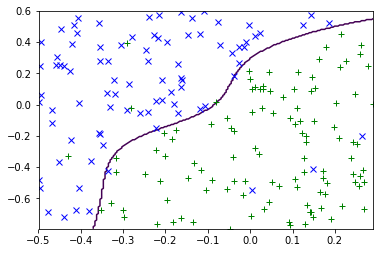

In [10]:
plotBoundary(X_val, y_val, clf, mesh = 200) # plots only validation values

It actually looks better than the hyperparameters set using the manual split of the data